# Constrained Finite Time Optimal Control (CFTOC) Trajectory Generator
Finite-time optimization is used to generate a smooth and feasible “overtaking” trajectory around the obstacle (ego) vehicle. The "mpc_vehicle_controller.ipynb" script will later use MPC to control a vehicle along this reference trajectory.

In [ ]:
# Please run this cell only if you are using Google Colab. 
# install required dependencies

import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64
  !pip install ttictoc

     |████████████████████████████████| 9.2 MB 5.2 MB/s 
     |████████████████████████████████| 49 kB 1.9 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-1_amd64.deb ...
Unpacking glpk-utils (4.65-1) ...
Setting up 

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2105
  Number of variables: 753
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 34.74746751785278
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
None

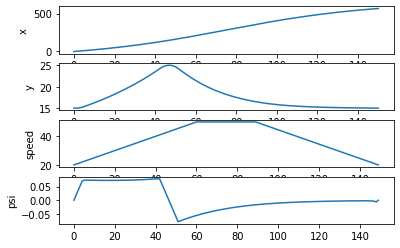

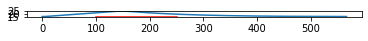

566.4249159853796 250.0
15.006299523978832 15.0
[1.6889118802245397e-48, 4.590938473882965e-48, 1.3115182992218353e-47, 3.934954641840945e-47, 1.2390586936506561e-46, 4.091714894296499e-46, 1.4193962502632747e-45, 5.175684377361416e-45, 1.9837981077183018e-44, 7.992678294661069e-44, 3.384947238553305e-43, 1.506869467334463e-42, 7.051197521492976e-42, 3.468270088111128e-41, 1.7931841365612137e-40, 9.745359742822638e-40, 5.5671230934219163e-39, 3.342893733076702e-38, 2.1099483914048886e-37, 1.3998361275381132e-36, 9.761962177764687e-36, 7.155663581441513e-35, 5.513326878696249e-34, 4.46505290574718e-33, 3.8008992123678664e-32, 3.400874741379195e-31, 3.1984305962576e-30, 3.1617134870256157e-29, 3.285068583583923e-28, 3.587563165443536e-27, 4.117982119557181e-26, 4.96815898477087e-25, 6.299828310430896e-24, 8.39614488030413e-23, 1.1761009134131139e-21, 1.7314814514838815e-20, 2.679134257521147e-19, 4.3568127410939554e-18, 7.446206724686732e-17, 1.3374779196249867e-15, 2.524739513039451e-14

In [ ]:
# Overtaking Trajectory Generator for Straight Road

import matplotlib.pyplot as plt
import numpy as np 
import pyomo.environ as pyo
from mpl_toolkits import mplot3d

# Simulation Parameters:
Ts = 0.1
N = 150
Nz = 2
Nu = 2

# Initial States:
initEgoState = [0, 15]
initEgoControl = [20, 0]
initObsState = [100, 15]
initObsControl = [10, 0]

# Define Obstacle State:
obsState = np.zeros((2, N+1))
obsControl = np.zeros((2, N+1))

for i in range(N + 1):
  obsControl[0, i] = initObsControl[0]
  obsControl[1, i] = initObsControl[1]
  obsState[0, i] = initObsState[0] + obsControl[0, i] * Ts * i
  obsState[1, i] = initObsState[1]

# Model Intitialize:
model = pyo.ConcreteModel()
model.tidx = pyo.Set(initialize=range(0, N + 1)) 
model.zidx = pyo.Set(initialize=range(0, Nz))
model.uidx = pyo.Set(initialize=range(0, Nu))

# Create state and input variables trajectory:
model.z = pyo.Var(model.zidx, model.tidx)
model.u = pyo.Var(model.uidx, model.tidx)
model.o = pyo.Var(model.tidx, initialize=0)

# Objective:
model.cost = pyo.Objective(expr = 5. * (model.z[1, N] - initEgoState[1])**2 + 5. * (model.u[0, N-1] - initEgoControl[0])**2 + 10. * (model.z[1, N] - model.z[1, N-1])**2
                           + 0.1 * sum((model.u[1, t+1] - model.u[1, t])**2 for t in model.tidx if t < N-1) 
                           - 10.0 * sum((model.z[0, t] - obsState[0, t]) for t in model.tidx if t < N)
                           #- model.mb, sense=pyo.minimize)
                           + 0.2 * sum((model.z[1, t] - obsState[1, t])**2 * (model.o[t])  for t in model.tidx if t < N)
                           + 0.05 * sum((model.z[1, t] - obsState[1, t] - 10)**2 * (1 - model.o[t])  for t in model.tidx if t < N), sense=pyo.minimize)

# Initial Constraints:
model.c1 = pyo.Constraint(model.zidx, rule=lambda model, i: model.z[i, 0] == initEgoState[i])
model.c2 = pyo.Constraint(model.uidx, rule=lambda model, j: model.u[j, 0] == initEgoControl[j])

# Model Constraints:
model.c3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + model.u[0, t] * pyo.cos(model.u[1, t]) * Ts if t < N else pyo.Constraint.Skip)
model.c4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + model.u[0, t] * pyo.sin(model.u[1, t]) * Ts if t < N else pyo.Constraint.Skip) 

# Speed & Acceleration Constraints:
model.c5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] <= 50 if t < N else pyo.Constraint.Skip)
model.c6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] >= initEgoControl[0] if t < N else pyo.Constraint.Skip)
model.c7 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t+1] - model.u[0, t] >= -5 * Ts if t < N-1 else pyo.Constraint.Skip)
model.c8 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t+1] - model.u[0, t] <= 5 * Ts if t < N-1 else pyo.Constraint.Skip)

# Angle and Angular Speed Constraints:
model.c9 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] >= -0.5 if t < N else pyo.Constraint.Skip)
model.c10 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] <= 0.5 if t < N else pyo.Constraint.Skip)
model.c11 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] >= -0.175 * Ts if t < N-1 else pyo.Constraint.Skip)
model.c12 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] <= 0.175 * Ts if t < N-1 else pyo.Constraint.Skip)

# Obstacle Constraints:
model.c13 = pyo.Constraint(model.tidx, rule=lambda model, t: (model.z[0, t] - obsState[0, t])**2 + (model.z[1, t] - obsState[1, t])**2 >= 100 if t < N else pyo.Constraint.Skip)

# Lane Constraints:
model.c14 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t] <= 30)
model.c15 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t] >= 10)

# Overtaking Constraint: 
model.c16 = pyo.Constraint(model.tidx, rule=lambda model, t: model.o[t] == 1/(1 + np.e**-(model.z[0, t] - obsState[0, t] - 10.)))

# Final Constraints:
#model.c17 = pyo.Constraint(expr = model.z[1, N] == initEgoState[1])
model.c18 = pyo.Constraint(model.uidx, rule=lambda model, j: model.u[j, N-1] == initEgoControl[j])

# Plot Results:
results = pyo.SolverFactory('ipopt').solve(model).write()

print(results)

egoXData = []
egoYData = []
egoVData = []
egoPData = []

for t in model.tidx:
  if t < (N+1):
      egoXData.append(pyo.value(model.z[0,t]))
      egoYData.append(pyo.value(model.z[1,t]))
  if t < N:
      egoVData.append(pyo.value(model.u[0,t]))
      egoPData.append(pyo.value(model.u[1,t]))

plt.figure()
plt.subplot(4,1,1)
plt.plot(egoXData)
plt.ylabel('x')
plt.subplot(4,1,2)
plt.plot(egoYData)
plt.ylabel('y')
plt.subplot(4,1,3)
plt.plot(egoVData)
plt.ylabel('speed')
plt.subplot(4,1,4)
plt.plot(egoPData)
plt.ylabel('psi')
plt.show()
plt.plot(egoXData,egoYData)
plt.plot(obsState[0,:],obsState[1,:],'r-')
plt.axis('scaled')
plt.show()

print(egoXData[N], obsState[0, N])
print(egoYData[N], obsState[1, N])
print(pyo.value(model.o[:]))

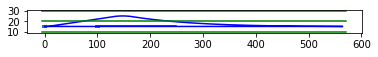

In [ ]:
# Overtaking Trajectory Animation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from random import randint
from matplotlib import rc
rc('animation', html='jshtml')

width = 2.5
length = 10

fig, ax = plt.subplots()

egoX = []
egoY = []

obsX = []
obsY = []

lowerLaneX = np.linspace(start=egoXData[0]-5, stop=egoXData[N]+5, num=100)
lowerLaneY = 10*np.ones(100)

middleLaneX = np.linspace(start=egoXData[0]-5, stop=egoXData[N]+5, num=100)
middleLaneY = 20*np.ones(100)

upperLaneX = np.linspace(start=egoXData[0]-5, stop=egoXData[N]+5, num=100)
upperLaneY = 30*np.ones(100)

def animate(i):
    egoX.append(egoXData[i])
    egoY.append(egoYData[i])

    obsX.append(obsState[0, i])
    obsY.append(obsState[1, i])

    ax.clear()
    ax.plot(obsX, obsY, c='r')
    ax.add_patch(Rectangle((egoX[-1] - length/2, egoY[-1] - width/2), length, width, angle=egoPData[i]*180/np.pi))
    ax.plot(egoX, egoY, c='b')
    ax.add_patch(Rectangle((obsX[-1] - length/2, obsY[-1] - width/2), length, width))
    ax.plot(lowerLaneX, lowerLaneY, c='g')
    ax.plot(middleLaneX, middleLaneY, c='g')
    ax.plot(upperLaneX, upperLaneY, c='g')
    plt.gca().set_aspect(2)
  
ani = FuncAnimation(fig, animate, frames=N, interval=100, repeat=False)
ani

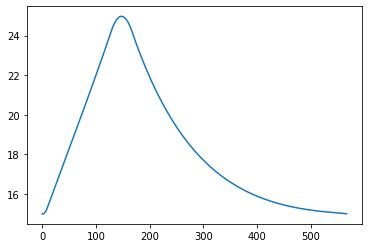

In [ ]:
egoXdata = np.array(egoXData)
egoXdata = egoXdata.reshape((1,151))
egoYdata = np.array(egoYData)
egoYdata = egoYdata.reshape((1,151))
egoVdata = np.array(egoVData)
egoVdata = np.append(egoVdata,egoVData[-1])
egoVdata = egoVdata.reshape((1,151))
egoPdata = np.array(egoPData)
egoPdata = np.append(egoPdata,egoPData[-1])
egoPdata = egoPdata.reshape((1,151))
combined_state_data1 = np.concatenate((egoXdata, egoYdata))
combined_state_data2 = np.concatenate((egoVdata, egoPdata))
combined_state_data = np.concatenate((combined_state_data1,combined_state_data2))
plt.plot(combined_state_data[0,:],combined_state_data[1,:])

0.003456615893179538


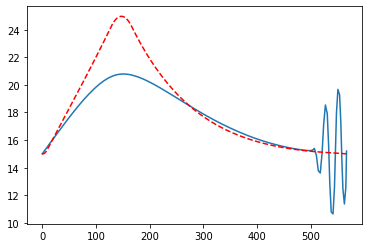

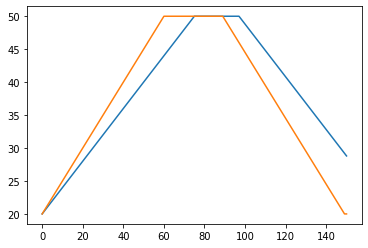

In [ ]:
nz = 4        # number of states
nu = 2         # number of inputs

l_r   = 1.738                  
def solve_cftoc(Ts,Nmodel,d,nz,nu,x0,stateData):
    model = pyo.ConcreteModel()
    model.tidx = pyo.Set(initialize=range(0, Nmodel+1)) # length of finite optimization problem
    model.zidx = pyo.Set(initialize=range(0, nz))
    model.uidx = pyo.Set(initialize=range(0, nu))

    # Create state and input variables trajectory:
    model.z = pyo.Var(model.zidx, model.tidx)
    model.u = pyo.Var(model.uidx, model.tidx)

    # Objective:
    model.cost = pyo.Objective(expr = 10*sum((model.z[i, Nmodel] - stateData[i,-1])**2 for i in model.zidx) + sum((model.z[0, t] - stateData[0,t])**2 + (model.z[1, t] - stateData[1,t])**2 + (model.z[2, t] - stateData[2,t])**2 for t in model.tidx), sense=pyo.minimize)

    # Constraints:

    model.constraint1 = pyo.Constraint(model.zidx, rule=lambda model, i: model.z[i, 0] == x0[i])
    model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + Ts*(model.z[2, t]*pyo.cos(model.z[3, t] + model.u[1, t] + 0.5*d))
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + Ts*(model.z[2, t]*pyo.sin(model.z[3, t] + model.u[1, t] + 0.5*d))
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[2, t+1] == model.z[2, t] + Ts*model.u[0, t]
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[3, t+1] == model.z[3, t] + Ts*(model.z[2, t]/l_r*pyo.sin(model.u[1, t]))
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] <= 4 
                                    if t < Nmodel else pyo.Constraint.Skip)
    model.constraint7 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] >= -4
                                    if t < Nmodel else pyo.Constraint.Skip)
    model.constraint8 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] <= 0.2
                                      if t < Nmodel-1 else pyo.Constraint.Skip)
    model.constraint9 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] >= -0.2
                                      if t < Nmodel-1 else pyo.Constraint.Skip)
    model.constraint10 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] >= -0.6
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint11 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] <= 0.6
                                      if t < Nmodel else pyo.Constraint.Skip) 
    model.constraint12 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[2, t] <= 50
                                      if t < Nmodel else pyo.Constraint.Skip)

                                                           

    # Now we can solve:
    results = pyo.SolverFactory('ipopt').solve(model)

    xOpt = np.asarray([[model.z[i,t]() for i in model.zidx] for t in model.tidx]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tidx]).T
    return [model, xOpt, uOpt]

xOpt = combined_state_data[:,0]
dtest= np.random.random()*0.1
print(dtest)
[a,b,c] = solve_cftoc(Ts,N,dtest,nz,nu,xOpt,combined_state_data)
plt.plot(b[0,:],b[1,:])
plt.plot(combined_state_data[0,:],combined_state_data[1,:],'r--')
plt.show()
plt.plot(b[2,:])
plt.plot(combined_state_data[2,:])
plt.show()

In [ ]:
# Saving and Exporting Generated Trajectories

M = 50  # Simulation steps
xOpt = np.zeros((4, N+1))
xOpt[:,0] = combined_state_data[:,0]
fig = plt.figure(figsize=(9, 6))
for t in range(0,M):
  print(t)
  [model, x, u] = solve_cftoc(Ts,N-t,nz,nu,xOpt[:,t],combined_state_data[:,t:])

  # Save closed loop trajectory
  # Note that the second column of x represents the optimal closed loop state
  xOpt[:,t+1] = x[:, 1]
for t in range(M,2*M):
  print(t)
  # print(N-t)
  [model, x, u] = solve_cftoc(Ts,N-t,nz,nu,xOpt[:,t],combined_state_data[:,t:])
  # plt.plot(x[0,:],x[1,:])
  # plt.show()
  xOpt[:,t+1] = x[:, 1]

# Plot Open Loop
line1 = plt.plot(combined_state_data[0,:], combined_state_data[1,:], 'r--')
# Plot Closed Loop
line2 = plt.plot(xOpt[0, :], xOpt[1,:], 'b-')
plt.legend('Closed-loop','Open Loop');
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

0


TypeError: ignored

<Figure size 648x432 with 0 Axes>